## Imports

In [1]:
%matplotlib inline
import os
import cv2
import json
import pyNN.brian2 as sim  # can of course replace `neuron` with `nest`, `brian`, etc.
from pyNN.standardmodels import STDPTimingDependence
import pyNN.random as pynn_rand
import pyNN.space as Space
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from components.AttractorLayer import AttractorLayer
from components.RadarLoader import RadarLoader
from components.SimulatedRadar import SimulatedRadar

seq_name = "2020-02-28-13-13-43"
%run carrada_utils/scripts/set_path.py 'components/carrada_datasets/'

In [2]:
from brian2 import *

In [3]:
SIZE_X = 32
SIZE_Y = 32

In [4]:
data_loader = RadarLoader(seq_name)
raw_camera_data = data_loader.get_color_image_datastream(resize=(SIZE_X,SIZE_Y))
spiking_data, spiking_indices = data_loader.get_spiking_ra_stream_differentiated_normalized_brian2(size_x=SIZE_X)
sim_data_loader = SimulatedRadar()
sim_spiking_data, sim_spiking_indices = sim_data_loader.get_random_datastream_spiking_brian2(size_x=SIZE_X)
ds = sim_data_loader.get_random_datastream()


In [5]:
len(ds)*100

11300

In [6]:
# TODO: Convert to brian2 input

In [7]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
    

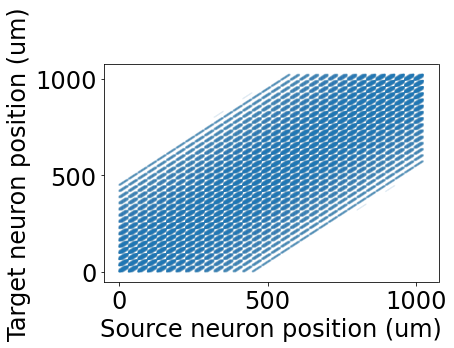

In [44]:
start_scope()
tau = 20*ms

# img = (1-imread('brian.png'))[::-1, :, 0].T
# num_samples, N = img.shape
# ta = TimedArray(img, dt=1*ms) # 228
#eqs = '''
#dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
#'''
eqs = '''
dv/dt = -v/tau : 1
x : meter
y : meter
'''

N = SIZE_X*SIZE_Y
#neuron_spacing = 50*umetre
rows = SIZE_X
cols = SIZE_Y
# initialize the grid positions
grid_dist = 50.0*umeter
sigma = N/500.0*grid_dist

conn_distance = 15*grid_dist


# Neuron has one variable x, its position
# G = NeuronGroup(N, 'x : metre')
# G.x = 'i*neuron_spacing'

G = NeuronGroup(N, eqs, threshold='v>1.0', reset='v = 0.0', method='exact')
G.x = '(i // rows) * grid_dist - rows/2.0 * grid_dist'
G.y = '(i % rows) * grid_dist - cols/2.0 * grid_dist'
# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(condition='(i!=j) and (sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2) < conn_distance)')

# Weight varies with distance
S.w = '0.01*exprel(-(sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2))**2/(2*sigma**2))'

scatter(S.i, S.j, S.w)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

In [45]:
S.w[6]

0.001706987238425088

In [46]:
G_input = SpikeGeneratorGroup(N, sim_spiking_indices, sim_spiking_data*ms)
weight=0.25
S_input = Synapses(G_input, G, on_pre='v += weight')
S_input.connect(i='j')

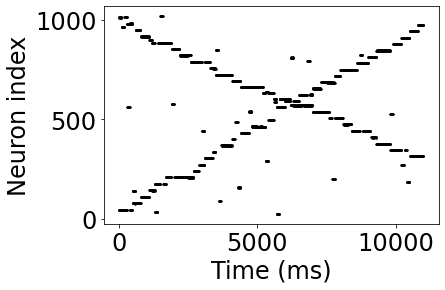

In [47]:
M_spike = SpikeMonitor(G)

M_state = StateMonitor(G, 'v', record=True)

run(11000*ms)


plot(M_spike.t/ms, M_spike.i, '.k', ms=3)
xlabel('Time (ms)')
ylabel('Neuron index');

In [11]:
# connections_ext.set(weight=0.5)
# connections_ext.set(weight=0.2)

In [12]:

sim.run(11000.0)

spikes_in = p_in.get_data('spikes')
data_out = p_out.get_data('spikes')

fig_settings = {
    'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'axes.labelsize': 'small',
    'legend.fontsize': 'small',
    'font.size': 8
}
plt.rcParams.update(fig_settings)
plt.figure(1, figsize=(6, 8))


def plot_spiketrains(segment):
    for spiketrain in segment.spiketrains:
        y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
        plt.plot(spiketrain, y, '.')
        plt.ylabel(segment.name)
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        
def plot_spiketrains_heatmap(segment):
    for spiketrain in segment.spiketrains:
        y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
        plt.plot(spiketrain, y, '.')
        plt.ylabel(segment.name)
        plt.setp(plt.gca().get_xticklabels(), visible=False)


n_panels = 2
plt.subplot(n_panels, 1, 1)
plot_spiketrains(spikes_in.segments[0])
# data_out_int = p_out.get_data('spikes')
# plot_spiketrains(data_out_int.segments[0])
plt.subplot(n_panels, 1, 2)
plot_spiketrains(data_out.segments[0])

plt.xlabel("time")
plt.setp(plt.gca().get_xticklabels(), visible=True)

plt.show()

NameError: name 'p_in' is not defined

In [ ]:
grid_input_mock = np.zeros((SIZE_X,SIZE_X))
grid_output_mock = np.zeros((SIZE_X,SIZE_X))
for ind_ in range(0,SIZE_X*SIZE_X):
    grid_input_mock[ind_//SIZE_X][ind_%SIZE_X]=((100.0 <  spikes_in.segments[0].spiketrains[ind_].times) & (spikes_in.segments[0].spiketrains[ind_].times < 200.0+10.0)).sum() # TODO: Check this equal or increase     
    grid_output_mock[ind_//SIZE_X][ind_%SIZE_X]=((100.0< data_out.segments[0].spiketrains[ind_].times) & (data_out.segments[0].spiketrains[ind_].times < 200.0+10.0)).sum() # TODO: Check this equal or increase           

                        
#210.0 in spikes_in.segments[0].spiketrains[37].times
fig,((ax1, ax2))= plt.subplots(1, 2, figsize=(8,4), dpi=200)

ax1.tick_params(axis='both',labelsize=8)
ax1.set_title("Input",fontsize=10)
input_map = ax1.imshow(grid_input_mock, cmap='hot', interpolation='none')

ax1.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax1.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])

ax1.set_yticklabels([50, 40, 30, 20, 10, 0])
ax1.set_xticklabels([-90, 0, 90])
ax1.set_ylabel('Distance (m)', fontsize=10)
ax1.set_xlabel('Angle (Degree)', fontsize=10)

# Neuron Activities
ax2.tick_params(axis='both',labelsize=8)
ax2.set_title(f"Output",fontsize=10)
output_map = ax2.imshow(grid_output_mock, cmap='hot', interpolation='none')

ax2.set_xticks([0, (SIZE_X-1)/2, SIZE_X-1])
ax2.set_yticks([0,
               SIZE_X*1/5-1,
               SIZE_X*2/5-1,
               SIZE_X*3/5-1,
               SIZE_X*4/5-1,
               SIZE_X-1])
ax2.set_yticklabels([50, 40, 30, 20, 10, 0])
ax2.set_xticklabels([-90, 0, 90])
ax2.set_ylabel('Distance (m)', fontsize=10)
ax2.set_xlabel('Angle (Degree)', fontsize=10)

In [ ]:
def init():
    grid_input = np.zeros((SIZE_X,SIZE_X))
    grid_output = np.zeros((SIZE_X,SIZE_X))
    for ind_ in range(0,SIZE_X*SIZE_X):
        grid_input[ind_//SIZE_X][ind_%SIZE_X]=((0*10.0 <  spikes_in.segments[0].spiketrains[ind_].times) & (spikes_in.segments[0].spiketrains[ind_].times < 0*10.0+10.0)).sum() # TODO: Check this equal or increase           

        grid_output[ind_//SIZE_X][ind_%SIZE_X]=((0*10.0< data_out.segments[0].spiketrains[ind_].times) & (data_out.segments[0].spiketrains[ind_].times < 0*10.0+10.0)).sum() # TODO: Check this equal or increase           
    input_map.set_data((grid_input).copy())
    output_map.set_data((grid_output).copy())
    return [input_map, output_map]


# animation function.  This is called sequentially
def animate(i):
    grid_input = np.zeros((SIZE_X,SIZE_X))
    grid_output = np.zeros((SIZE_X,SIZE_X))
    for ind_ in range(0,SIZE_X*SIZE_X):
        grid_input[ind_//SIZE_X][ind_%SIZE_X]=((i*100.0 <  spikes_in.segments[0].spiketrains[ind_].times) & (spikes_in.segments[0].spiketrains[ind_].times < i*100.0+100.0)).sum() # TODO: Check this equal or increase           

        grid_output[ind_//SIZE_X][ind_%SIZE_X]=((i*100.0< data_out.segments[0].spiketrains[ind_].times) & (data_out.segments[0].spiketrains[ind_].times < i*100.0+100.0)).sum() # TODO: Check this equal or increase           
    input_map.set_data((grid_input).copy())
    output_map.set_data((grid_output).copy())
    return [input_map, output_map]

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=int(2000.0/10.0)-3, interval=1, blit=True)


FFwriter = animation.FFMpegWriter(fps=10, extra_args=["-vcodec", "libx264"])
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=int(11000.0/100.0)-3, interval=1, blit=True
)

anim.save(f"animations/vis_spike_normal_32.mp4", FFwriter)

# anim.save(f'animations/vis_spiking.gif', fps=10)

# from IPython.display import Image, display
# with open(f'animations/vis_spiking.gif','rb') as file:
#     display(Image(file.read()))

In [ ]:
%matplotlib inline
import matplotlib
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128
HTML(anim.to_jshtml())
